In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import os
from pathlib import Path
import datetime
import math

from sklearn.neighbors import NearestNeighbors

import tensorflow as tf
import tensorflow_io as tfio
from tensorflow_probability import distributions as tfd

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose,Dense, BatchNormalization, Dropout, Add, Concatenate, AveragePooling2D
from tensorflow.keras.regularizers import l1, l2, l1_l2

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

from tensorflow.keras.utils import plot_model

# Image Colorization Model "Ipix" - DATA PREPARING
## Author: Tsvetoslav Nikolov
### Image colorization model implemented in Ipix

# Abstract
To do

# Introduction

This project is separated in two main parts(I - Data preprocessing, creating the dataset, exploring different methods for training and optimization, II - Model Architecture, Model training and fine-tuning)

# Dataset
In the previous section(in the notebook with title "Ipix Colorization Data Prepare") I explained the whole plan and the pipeline(two variants - tfrecords and local training vs real-time data preprocessing and cloud training, choose ti try them both and compare the result, blah-blah :D). Here is the code for the "local" variant, but the only difference campared to the cloud is the first "parse" function(we have to compute the values, not just read them as bytes, because we don't have 3TB storage on the VM). So now let's see how it will work.

If you read the tensorflow docs about tf.data.Dataset, you will probably see that we have to batch as soon as we can to gain more speed.

## Dataset with TFRecords(Mainly for local training)

In [3]:
BATCH_SIZE = 16
H = 256
W = 256

GD = tfd.Sample(tfd.Geometric(probs=1.5e-1))
MVN = tfd.Sample(tfd.MultivariateNormalDiag(loc = [H/2, W/2], scale_diag = [H/4, W/4]))

feature_description = {
    'image_rgb': tf.io.FixedLenFeature([], tf.string),
    'gamut_dist': tf.io.FixedLenFeature([], tf.string),
    'global_stats': tf.io.FixedLenFeature([], tf.string),
}

def _parse_function(example_proto):
    parsed_data = tf.io.parse_single_example(example_proto, feature_description)
    
    image_rgb = tf.image.decode_jpeg(parsed_data["image_rgb"], channels = 3)
    gamut_distribution = tf.io.parse_tensor(parsed_data["gamut_dist"], tf.uint8)
    
    # 20% of the data will be with global stats
    if tf.random.uniform([]) < 0.20:
        global_stats = tf.io.parse_tensor(parsed_data["global_stats"], tf.float32)
    else:
        global_stats = tf.zeros((1, 1, 317))

    points_count = GD.sample()
    if points_count != 0:
        points_xy = MVN.sample(points_count)
        points_xy = tf.cast(points_xy, tf.int32)
        points_xy = tf.clip_by_value(points_xy, [0, 0], [255, 255])
        points_values = tf.gather_nd(image_rgb, points_xy)
        points_mask = tf.scatter_nd(points_xy, points_values, (256, 256, 3))
    else:
        points_mask = tf.zeros((256, 256, 3), dtype=tf.uint8)
        
    return image_rgb, gamut_distribution, points_mask, global_stats
    
    
def unbox_reduced_gamut_encoding(reduced_encoding):
    to_shape = [BATCH_SIZE, 16384, 313]

    # Create additional indices
    i1, i2 = tf.meshgrid(tf.range(BATCH_SIZE),
                         tf.range(16384), indexing="ij")

    i1 = tf.tile(i1[:, :, tf.newaxis], [1, 1, 6])
    i2 = tf.tile(i2[:, :, tf.newaxis], [1, 1, 6])

    #Create final indices
    idx = tf.stack([i1, i2, tf.cast(reduced_encoding[:, :, :, 0], tf.int32) ], axis=-1)

    #Get scattered tensor
    output = tf.scatter_nd(idx, reduced_encoding[:, :, :, 1], to_shape)
    
    #Get probabilities
    output = tf.cast(output, tf.float32) / 255.
    
    output = tf.reshape(output, [-1, 128, 128, 313])
    return output

def preprocess_data(image_rgb, gamut_distribution, user_points_mask, global_stats):
    
    gamut_distribution = unbox_reduced_gamut_encoding(gamut_distribution)
    
    # 10% of the data flipped
    if  tf.random.uniform([]) < 0.10:
        image_rgb = tf.reverse(image_rgb, [2])
        gamut_distribution = tf.reverse(gamut_distribution, [2])
        user_points_mask = tf.reverse(user_points_mask, [2])

    
    image_l = tfio.experimental.color.rgb_to_lab(tf.cast(image_rgb, tf.float32) / 255.)[:, :, :, :1]
    image_l = image_l * 255 / 100
    
    greyscale_image = tf.image.grayscale_to_rgb(image_l)
    greyscale_image = tf.tensor_scatter_nd_update(greyscale_image,
                                                  tf.where(user_points_mask != 0), 
                                                  tf.gather_nd(tf.cast(user_points_mask, tf.float32), tf.where(user_points_mask != 0)))
        
    greyscale_VGG_input = tf.image.resize(greyscale_image, [224, 224])
    greyscale_VGG_input = preprocess_input(greyscale_VGG_input)
        
    greyscale_main_net_input = preprocess_input(greyscale_image)
    
    return (greyscale_main_net_input, greyscale_VGG_input, global_stats), gamut_distribution 

*Datasets lengths from the previuos notebook

In [4]:
sampled = True

In [5]:
train_len = 1809879 if not sampled else 0.18 * 1809879
test_len = 331054  
val_len = 38304

In [6]:
training_data_dir = Path(os.getcwd()).parent  / "Data" / "DatasetsMix" / "TFRecords_256" / "Train_sampled_smallset"
val_data_path = Path(os.getcwd()).parent  / "Data" / "DatasetsMix" / "TFRecords_256" / "Val" / "val.0.tfrecord"
test_data_path = Path(os.getcwd()).parent  / "Data" / "DatasetsMix" / "TFRecords_256" / "Test"/ "test.0.tfrecord"

# To make global shuffle on all files
train_ds_files = tf.data.Dataset.list_files(str(training_data_dir / '*'), shuffle=True, seed=4321)

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.TFRecordDataset(train_ds_files, compression_type="GZIP")
train_ds = train_ds.shuffle(1024)
train_ds = train_ds.map(_parse_function, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.apply(tf.data.experimental.ignore_errors())
train_ds = train_ds.repeat()
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

val_ds = tf.data.TFRecordDataset(str(val_data_path), compression_type="GZIP")
val_ds = val_ds.map(_parse_function, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.apply(tf.data.experimental.ignore_errors())
val_ds = val_ds.repeat()
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

test_ds = tf.data.TFRecordDataset(str(test_data_path), compression_type="GZIP")
test_ds = test_ds.map(_parse_function, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.map(preprocess_data, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.apply(tf.data.experimental.ignore_errors())
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

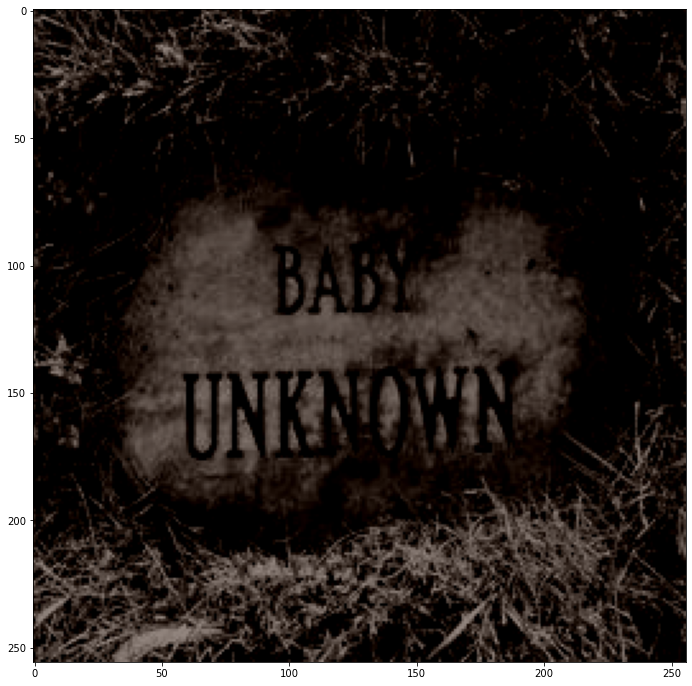

In [8]:
for i in train_ds.take(1):
    t = tf.cast(i[0][0][0], tf.uint8)
    plt.figure(figsize=(12, 12))
    plt.imshow(t)

## Dataset without TFRecords(for cloud usage)
Here I will copy some of the code from the previous notebook where I explaned everything about the way this magic works.

In [9]:
# training_data_dir = Path(os.getcwd()).parent  / "Data" / "DatasetsMix" / "256" / "data_256"
# val_data_dir = Path(os.getcwd()).parent  / "Data" / "DatasetsMix" / "256" / "val_256"
# test_data_dir = Path(os.getcwd()).parent  / "Data" / "DatasetsMix" / "256" / "test_256"

# train_ds = tf.data.Dataset.list_files(str(training_data_dir / '*/*'), shuffle=True)
# val_ds = tf.data.Dataset.list_files(str(val_data_dir / '*'), shuffle=False)
# test_ds = tf.data.Dataset.list_files(str(test_data_dir / '*'), shuffle=False)

In [10]:
color_space = np.load("./assets/pts_in_hull.npy")
kn = NearestNeighbors(n_neighbors=6, algorithm="ball_tree", n_jobs = -1).fit(color_space)

def get_soft_encoding(img_lab, sigma = 5.):
    """Compute The Soft-Encoded Vector, but as tensor where every pixel has (5, 2) 
    values (indeces, smoothed probabilties) in order to reduce the size of the result"""
    lab_resized = tf.image.resize(img_lab, [128, 128])
    ab = tf.reshape(lab_resized[:, :, 1:], [-1, 2])
    dist, ids = kn.kneighbors(ab)

    #dist is float64 - > float32
    dist = tf.convert_to_tensor(dist, tf.float32)
    smoothed_dist = tf.math.exp(-dist ** 2 / (2 * sigma ** 2))
    smoothed_dist = smoothed_dist / tf.math.reduce_sum(smoothed_dist, axis=1)[:, tf.newaxis]

    #Stacking and converting back to tensors at the same time(and casting to float32 because the numpy result is in float64)
    smoothed_ab_encoding = tf.stack([ids, smoothed_dist], axis=-1)

    return smoothed_ab_encoding

def _parse_without_tfrecords(file):
    image_rgb = tf.io.read_file(file)
    image_rgb = tf.image.decode_jpeg(image_rgb)
    
    image_rgb_norm = tf.cast(image_rgb, tf.float32) / 255.
    image_lab = tfio.experimental.color.rgb_to_lab(image_rgb_norm)
    
    points_count = GD.sample()
    points_xy = MVN.sample(points_count)
    points_xy = tf.cast(points_xy, tf.int32)
    points_xy = tf.clip_by_value(points_xy, [0, 0], [255, 255])
    
    if points_xy.shape[0] != 0:
        print("We have")
        points_values = tf.gather_nd(image_rgb, points_xy)
        points_mask = tf.scatter_nd(points_xy, points_values, (256, 256, 3))
    else:
        points_mask = tf.zeros((256, 256, 3))
    
    gamut_distribution = tf.py_function(get_soft_encoding, [image_lab], tf.float32)
    
    return image_rgb, image_lab, gamut_distribution, points_mask


def preprocess_without_tfrecords(images_rgb, images_lab, gamut_distributions, points_mask):

    greyscale_images = tf.image.grayscale_to_rgb(images_lab[:, :, :, :1]) * 255 / 100
    greyscale_VGG_input = tf.image.resize(greyscale_images, [224, 224])
    greyscale_VGG_input = preprocess_input(greyscale_VGG_input)
      
    #GAMUT
    gamut_distributions = unbox_reduced_gamut_encoding(gamut_distributions)
    
    #Global stats
    user_defined = tf.ones((BATCH_SIZE, 1))
    gamut_mean = tf.reduce_mean(gamut_distributions, axis=1)
    
    #Compute std for R, G and B
    images_rgb = tf.cast(images_rgb, tf.float32)
    RMSContrast = tf.math.reduce_std(tf.reshape(images_rgb , [BATCH_SIZE, 65536, 3]), axis=1) / 255.

    # Concatenate
    global_stats_vector = tf.concat([gamut_mean, RMSContrast, user_defined], axis=1)
    print(global_stats_vector)

    
    # Create input tensor with shape (1, 1, -1)
    global_stats_vector_input_tensor = tf.reshape(global_stats_vector, [-1, 1, 1, 317]) / 255.

    return greyscale_images, greyscale_VGG_input, gamut_distributions, global_stats_vector_input_tensor


###IF WE YOU WANT TO TRAIN IT ON A CLOUD AND YOU DO NOT HAVE ENOUGH MEMORY THE CREATE THE TFRecords, 
###YOU CAN USE THE FUNCTIONS ABOVE AND MAP THEM TO THE DATASET CONTAINING THE FILENAMES

# Model
We know the task. From both greyscale + user hints and global statistics we shoud be able to approximate the gamut distribution over 313ab color bins. Because training most of the cases is very very slow, here we can't do fine-tuning on all of the hyperparameters so we will do fine-tuning and optimization depending on the time(first the most important ones like learning rate :D).

The model architecture will be a mix between different architectures. We will experiment with them in different manners(all credits are given at the end :D).

Blah blah

## Loading fundamental models for transfer learning

In [11]:
vgg16_base_arch = VGG16(include_top = True, weights=None)
x = vgg16_base_arch.layers[-2].output
pred = Dense(365, activation='softmax', name="places_predictions")(x)
vgg16_places = Model(inputs=vgg16_base_arch.input, outputs = pred)
vgg16_places.load_weights(r"./assets/vgg16-places365_weights_tf_dim_ordering_tf_kernels.h5")

for layer in vgg16_places.layers:
    
    #Adding a postfix to the layers names
    layer._name = layer.name + str('_classification')
    
    #We do not want to train those layers :D
    layer.trainable = False
    
vgg16_places.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1_classification (Inpu [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1_classification  (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2_classification  (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool_classification ( (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1_classification  (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2_classification  (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool_classification ( (None, 56, 56, 128)       0     

In [12]:
vgg16_main_net = VGG16(include_top=False, input_shape=(256, 256, 3), weights=None)
vgg16_main_net.load_weights(r"./assets/vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5")

for layer in vgg16_main_net.layers:
    layer._name = layer.name + str('_main_net')
    layer.trainable = False
vgg16_main_net.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2_main_net (InputLayer [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1_main_net (Conv2 (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2_main_net (Conv2 (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool_main_net (MaxPoo (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1_main_net (Conv2 (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2_main_net (Conv2 (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool_main_net (MaxPoo (None, 64, 64, 128)       0     

## Custom Layers

In [13]:
class FushionBlock(tf.keras.layers.Layer):

    def __init__(self, input_width_height = (32, 32), classes_count = 365):
        super(FushionBlock, self).__init__()
        self.repeat = tf.keras.layers.RepeatVector(input_width_height[0] * input_width_height[1])
        self.reshape = tf.keras.layers.Reshape([*input_width_height, classes_count])
        self.concat = Concatenate(axis=-1)

    def call(self, main_net_out, class_net_out):
        class_net_out = self.repeat(class_net_out)
        class_net_out = self.reshape(class_net_out)
        fused_features = self.concat([main_net_out, class_net_out])
        return fused_features
    
    def get_config(self):
        cfg = super().get_config()
        return cfg   

In [14]:
class HaarKernelInitializer(tf.keras.initializers.Initializer):

    def __init__(self, kernel_type):
        self.kernel_type = kernel_type

        if kernel_type == "LL":
            self.kernel_weights = tf.constant([0.5, 0.5, 0.5, 0.5], shape=(2, 2))
        elif kernel_type == "LH":
            self.kernel_weights = tf.constant([-0.5, 0.5, -0.5, 0.5], shape=(2, 2))
        elif kernel_type == "HL":
            self.kernel_weights = tf.constant([-0.5, -0.5, 0.5, 0.5], shape=(2, 2))
        elif kernel_type == "HH":
            self.kernel_weights = tf.constant([0.5, -0.5, -0.5, 0.5], shape=(2, 2))
        else:
            raise Exception("Kernel must be in ['LL', 'LH', 'HL', 'HH']")

    def __call__(self, shape, dtype=None, **kwargs):
        harr_kernels = tf.tile(self.kernel_weights[:, :, tf.newaxis, tf.newaxis], [1, 1, shape[2], shape[3]])
        return harr_kernels

In [15]:
class WaveletBlock(tf.keras.layers.Layer):
  
    def __init__(self, filters, pooling = True):
        super(WaveletBlock, self).__init__()
        if pooling:
            self.convLL = Conv2D(filters, kernel_size = 2, strides = 2, padding="same", kernel_initializer = HaarKernelInitializer("LL"), use_bias = False, trainable = False)
            self.convLH = Conv2D(filters, kernel_size = 2, strides = 2, padding="same", kernel_initializer = HaarKernelInitializer("LH"), use_bias = False, trainable = False)
            self.convHL = Conv2D(filters, kernel_size = 2, strides = 2, padding="same", kernel_initializer = HaarKernelInitializer("HL"), use_bias = False, trainable = False)
            self.convHH = Conv2D(filters, kernel_size = 2, strides = 2, padding="same", kernel_initializer = HaarKernelInitializer("HH"), use_bias = False, trainable = False)
        else:
            self.convLL = Conv2DTranspose(filters, kernel_size = 2, strides = 2, padding="same", kernel_initializer = HaarKernelInitializer("LL"), use_bias = False, trainable = False)
            self.convLH = Conv2DTranspose(filters, kernel_size = 2, strides = 2, padding="same", kernel_initializer = HaarKernelInitializer("LH"), use_bias = False, trainable = False)
            self.convHL = Conv2DTranspose(filters, kernel_size = 2, strides = 2, padding="same", kernel_initializer = HaarKernelInitializer("HL"), use_bias = False, trainable = False)
            self.convHH = Conv2DTranspose(filters, kernel_size = 2, strides = 2, padding="same", kernel_initializer = HaarKernelInitializer("HH"), use_bias = False, trainable = False)

    def call(self, inputs):
        LL = self.convLL(inputs)
        LH = self.convLH(inputs)
        HL = self.convHL(inputs)
        HH = self.convHH(inputs)

        return LL, LH, HL, HH


class WaveletPooling(tf.keras.layers.Layer):
  
    def __init__(self, filters):
        super(WaveletPooling, self).__init__()
        self.waveblock = WaveletBlock(filters)  

    def call(self, inputs):
        LL, LH, HL, HH = self.waveblock(inputs)

        return LL, LH, HL, HH
    def get_config(self):
        cfg = super().get_config()
        return cfg   

class WaveletUnpooling(tf.keras.layers.Layer):

    def __init__(self, filters):
        super(WaveletUnpooling, self).__init__()
        self.waveblock = WaveletBlock(filters, pooling=False)  

    def call(self, LL, LH, HL, HH):
        LL = self.waveblock.convLL(LL)
        LH = self.waveblock.convLH(LH)
        HL = self.waveblock.convHL(HL)
        HH = self.waveblock.convHH(HH)

        return LL, LH, HL, HH
    
    def get_config(self):
        cfg = super().get_config()
        return cfg   

## Defining the model
When we think of tensorflow and keras models in an easier way, there are almost three variants. 
1. Sequential models
2. Funtional API
2. Model subclassing

The most important thing is to know the overall diffuculty of your project. If the model shoud have multuple inputs or outputs and probably some connections in the middle part(hidden layers), you cannot use the sequential :( 

To be honest I've tried the model subclassing and it is very convinient especially if you have some experience with OOP. But there is a rule, if something can be done in a easier manner, just do it! Everything which is special about the model is in the custom layers and we can implement it via functional api. Model subclassing is for cases where we shoud have something more persice in the forward or in the training steps(like recurrent networks etc.).

In [16]:
GS_DROPOUT = 0.1
MAIN_REGULARIZER = tf.keras.regularizers.l1_l2(1e-3, 4e-3)
GLOBAL_STATS_REGULARIZER = tf.keras.regularizers.l1(4e-3)

def define_whole_model():
    base_input = vgg16_main_net.input
    vgg16_input = vgg16_places.input
    global_stats_input = Input((1, 1, 317), name = "global_stats_input")

    ### Main Net
    block1 = vgg16_main_net.layers[2].output
    LL_1, LH_1, HL_1, HH_1 = WaveletPooling(64)(block1)
    LH_1 = tf.keras.layers.experimental.preprocessing.Resizing(64, 64)(LH_1)
    HL_1 = tf.keras.layers.experimental.preprocessing.Resizing(64, 64)(HL_1)
    HH_1 = tf.keras.layers.experimental.preprocessing.Resizing(64, 64)(HH_1)

    x = vgg16_main_net.layers[4](LL_1)
    block2 = vgg16_main_net.layers[5](x)

    LL_2, LH_2, HL_2, HH_2 = WaveletPooling(128)(block2)

    LH_skip_1 = Concatenate(axis=-1)([LH_1, LH_2])
    HL_skip_1 = Concatenate(axis=-1)([HL_1, HL_2])
    HH_skip_1 = Concatenate(axis=-1)([HH_1, HH_2])

    block1 = AveragePooling2D()(block1)
    block_skip_1 = Concatenate(axis=-1)([block1, block2])

    x = vgg16_main_net.layers[7](LL_2)
    x = vgg16_main_net.layers[8](x)
    x = vgg16_main_net.layers[9](x)

    block_skip_2 = Conv2D(256, kernel_size = 3, padding="same", dilation_rate=2, activation="relu", kernel_regularizer = MAIN_REGULARIZER)(x)
    block_skip_2 = Conv2D(256, kernel_size = 3, padding="same", activation="relu", kernel_regularizer = MAIN_REGULARIZER)(block_skip_2)
    block_skip_2 = BatchNormalization()(block_skip_2)
    LL_3, LH_skip_2, HL_skip_2, HH_skip_2 = WaveletPooling(256)(block_skip_2)

    main_net_out = Conv2D(filters=512, kernel_size = 3, padding="same", dilation_rate=2, activation="relu", kernel_regularizer = MAIN_REGULARIZER)(LL_3)

    ###GLOBAL STATS NET
    global_stats = Conv2D(128, kernel_size = 1, padding="same", activation="relu", kernel_regularizer = GLOBAL_STATS_REGULARIZER)(global_stats_input)

    global_stats = Conv2D(256, kernel_size = 1, padding="same", activation="relu", kernel_regularizer = GLOBAL_STATS_REGULARIZER)(global_stats)
    global_stats = Dropout(GS_DROPOUT)(global_stats)
    global_stats = Conv2D(256, kernel_size = 1, padding="same", activation="relu", kernel_regularizer = GLOBAL_STATS_REGULARIZER)(global_stats)
    global_stats = BatchNormalization()(global_stats)

    global_stats = Conv2D(512, kernel_size = 1, padding="same", activation="relu", kernel_regularizer = GLOBAL_STATS_REGULARIZER)(global_stats)
    global_stats = Dropout(GS_DROPOUT)(global_stats)
    global_stats = Conv2D(512, kernel_size = 1, padding="same", activation="relu", kernel_regularizer = GLOBAL_STATS_REGULARIZER)(global_stats)
    global_stats = BatchNormalization()(global_stats)

    ###Bottleneck
    bottleneck_main_and_gs = Add()([main_net_out, global_stats])
    bottleneck_main_and_gs = Conv2D(512, kernel_size = 3, padding="same", activation="relu", kernel_regularizer = MAIN_REGULARIZER)(bottleneck_main_and_gs)

    vgg_classification = vgg16_places.output
    bottleneck_all = FushionBlock()(bottleneck_main_and_gs, vgg_classification)
    bottleneck_all = Conv2D(512, kernel_size = 1, padding = "same", activation = "relu", kernel_regularizer = MAIN_REGULARIZER)(bottleneck_all)

    ### DECODER
    x_dec = Conv2D(512, kernel_size=3, strides=1, padding="same", activation="relu", kernel_regularizer = MAIN_REGULARIZER)(bottleneck_all)
    x_dec = Conv2D(512, kernel_size=3, strides=1, padding="same", activation="relu", kernel_regularizer = MAIN_REGULARIZER)(x_dec)
    x_dec = BatchNormalization()(x_dec)
    iLL_2, iLH_2, iHL_2, iHH_2 = WaveletUnpooling(256)(x_dec, LH_skip_2, HL_skip_2, HH_skip_2)
    IWD_2 = Add()([iLL_2, iLH_2, iHL_2, iHH_2])
    IWD_2 = Concatenate(axis = -1)([IWD_2, block_skip_2])

    x_dec = Conv2D(256, kernel_size=3, strides=1, padding="same", activation="relu", kernel_regularizer = MAIN_REGULARIZER)(IWD_2)
    x_dec = Conv2D(256, kernel_size=3, strides=1, padding="same", activation="relu", kernel_regularizer = MAIN_REGULARIZER)(x_dec)
    x_dec = Conv2D(256, kernel_size=3, strides=1, padding="same", activation="relu", kernel_regularizer = MAIN_REGULARIZER)(x_dec)
    x_dec = BatchNormalization()(x_dec)

    x_dec = Conv2D(192, kernel_size=1, strides=1, padding="same", activation="relu", kernel_regularizer = MAIN_REGULARIZER)(x_dec)
    iLL_1, iLH_1, iHL_1, iHH_1 = WaveletUnpooling(192)(x_dec, LH_skip_1, HL_skip_1, HH_skip_1)
    IWD_1 = Add()([iLL_1, iLH_1, iHL_1, iHH_1])
    IWD_1 = Concatenate(axis = -1)([IWD_1, block_skip_1])

    x_dec = Conv2D(128, kernel_size=3, strides=1, padding="same", activation="relu", kernel_regularizer = MAIN_REGULARIZER)(IWD_1)
    x_dec = Conv2D(128, kernel_size=3, strides=1, padding="same", activation="relu", kernel_regularizer = MAIN_REGULARIZER)(x_dec)
    x_dec = BatchNormalization()(x_dec)

    # Output (H/2, W/2, 313)
    gamut_probs = Conv2D(313, kernel_size=1, strides=1, padding="same", activation="softmax")(x_dec)
    
    final_model = Model(inputs = [vgg16_main_net.input, vgg16_places.input, global_stats_input], outputs = gamut_probs, name="Ipix")

    return final_model

colorizer = define_whole_model()

In [17]:
colorizer.summary()

Model: "Ipix"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_classification (InputLa [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1_classification (Co (None, 224, 224, 64) 1792        input_1_classification[0][0]     
__________________________________________________________________________________________________
block1_conv2_classification (Co (None, 224, 224, 64) 36928       block1_conv1_classification[0][0]
__________________________________________________________________________________________________
block1_pool_classification (Max (None, 112, 112, 64) 0           block1_conv2_classification[0][0]
_______________________________________________________________________________________________

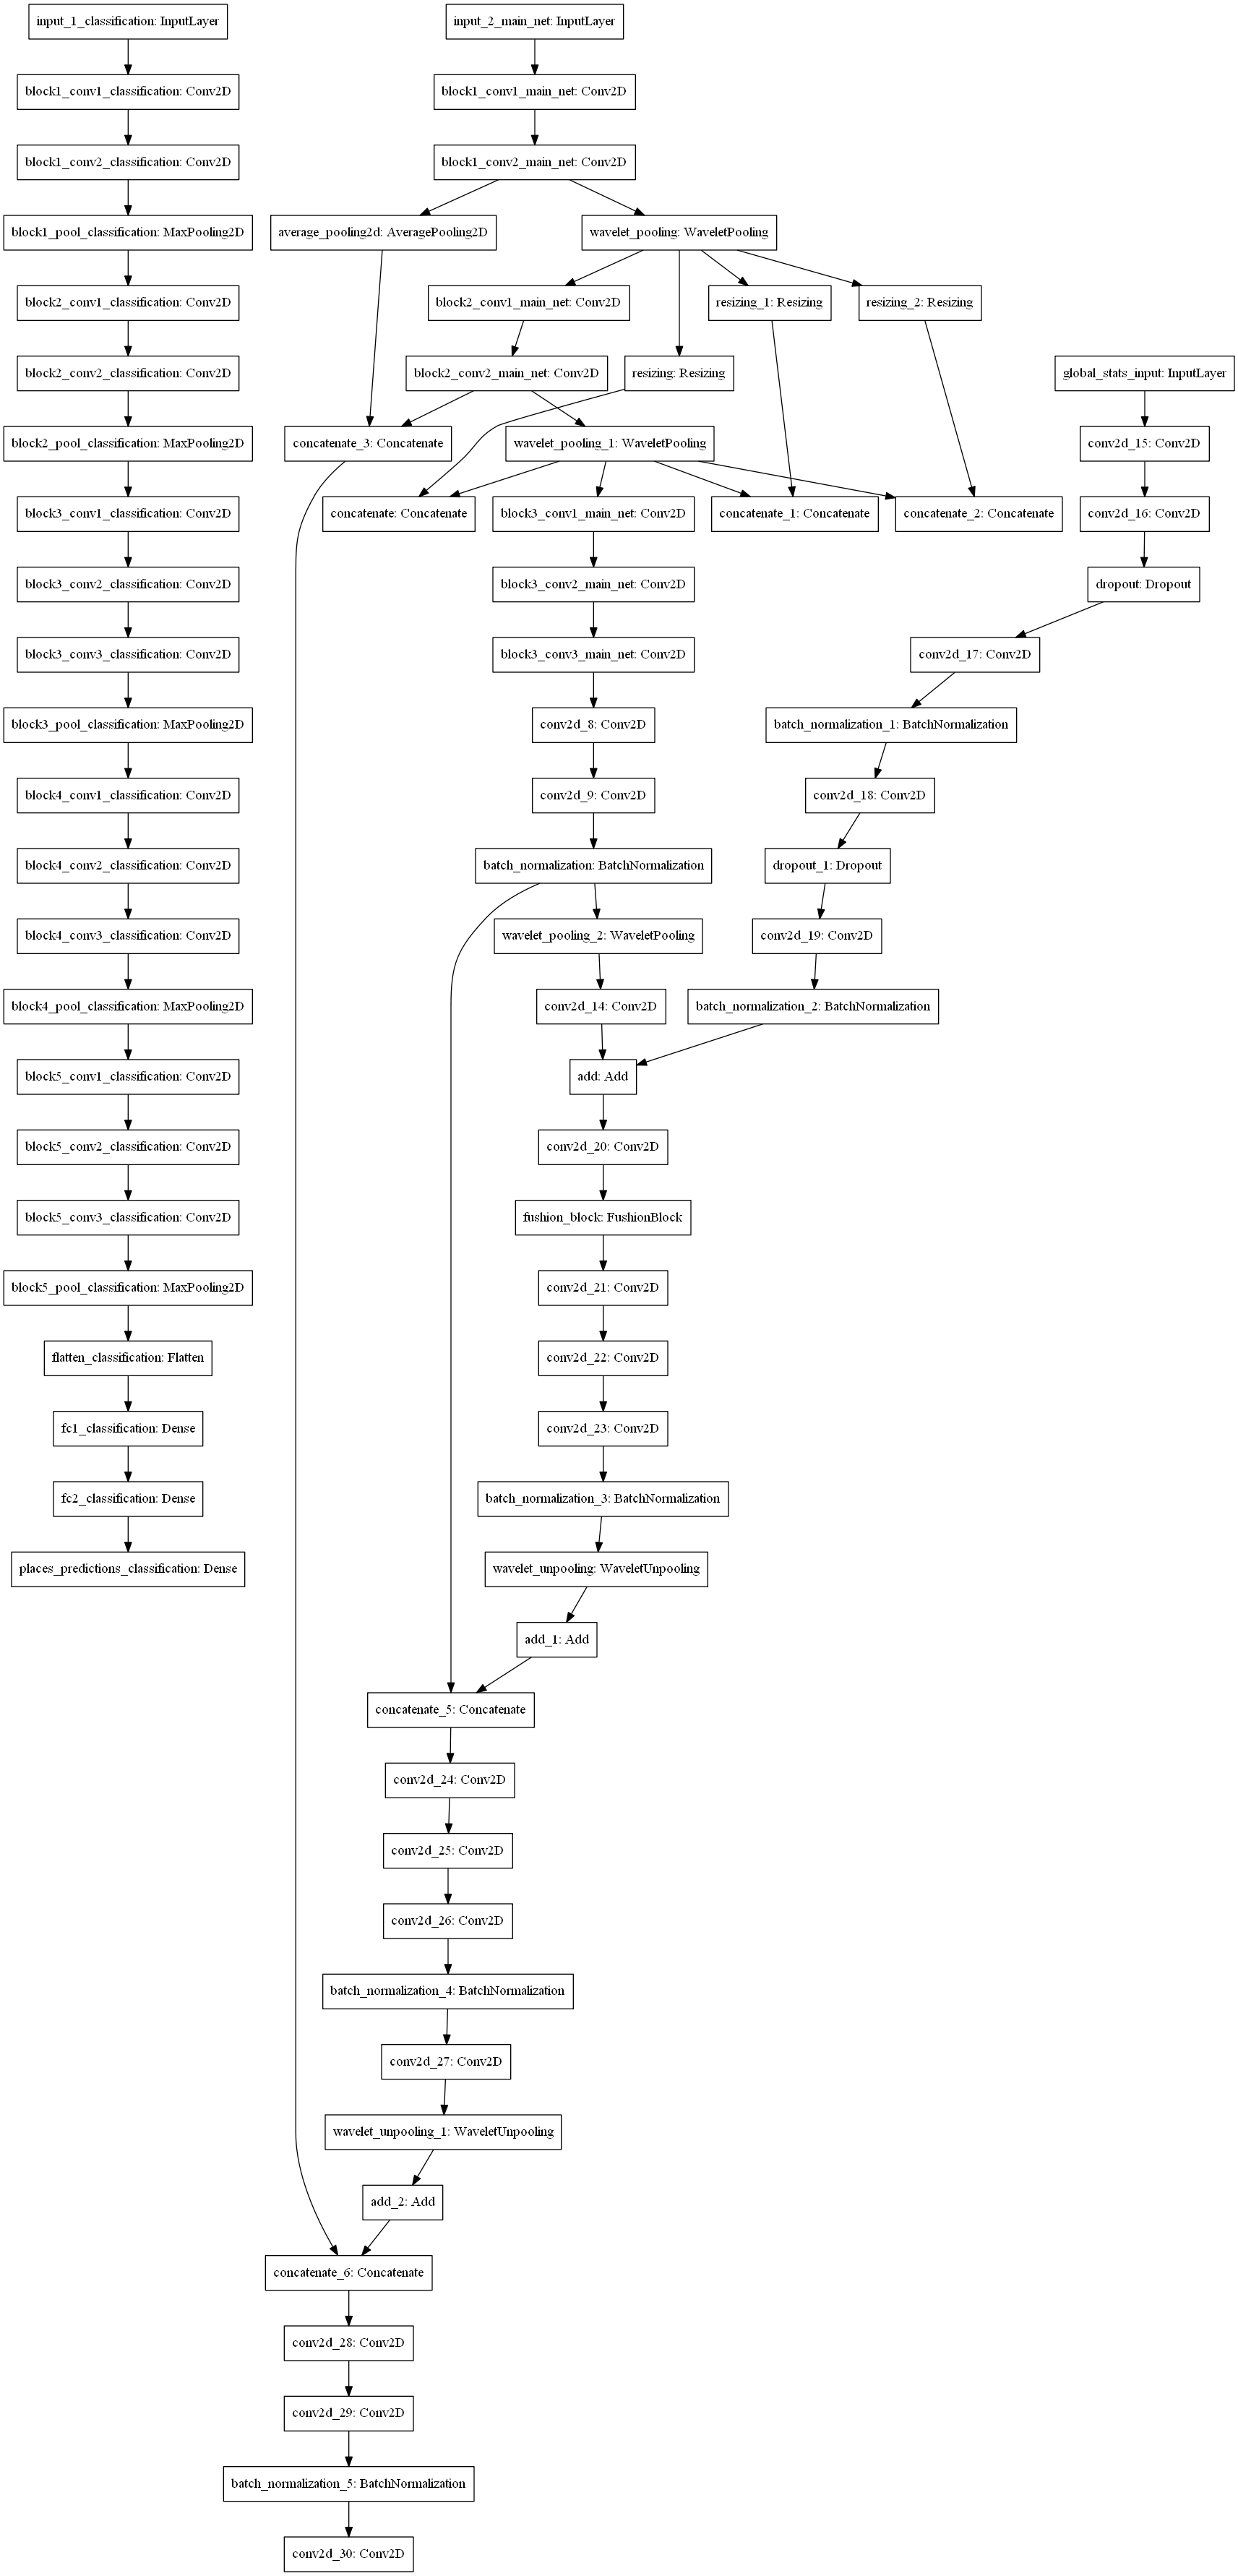

In [18]:
plot_model(colorizer, "./assets/model.png")

# Training

### Model checkpoints

In [19]:
steps_per_epoch = int(train_len / BATCH_SIZE)
tensoarboard_fq = int(steps_per_epoch / 5)

In [20]:
train_probe_spe = int(steps_per_epoch / 2000)
train_probe = train_ds.take(train_probe_spe)
val_probe_spe = int(int(val_len / BATCH_SIZE) / 900)
val_probe = val_ds.take(val_probe_spe)

In [21]:
colorizer.compile(
    optimizer = Adam(),
    loss = categorical_crossentropy,
    metrics = [
        tf.keras.metrics.CategoricalCrossentropy(),
        tf.keras.metrics.CategoricalAccuracy(),
    ]
)

In [22]:
# Define configuration parameters
start_lr = 1e-2

# Learning Rate for the first epoch
warm_lr = 1e-1

# Learning Rate Lim
min_lr = 1e-4

rampup_epochs = 4
exp_decay = 5e-2

# Define the scheduling function
def schedule(epoch):
    def lr(epoch, start_lr, rampup_epochs, exp_decay):
        if epoch < int(rampup_epochs / 2):
            return warm_lr
        elif epoch < rampup_epochs:
            return warm_lr / 2 if warm_lr / 2 > start_lr else start_lr
        else:
            return start_lr * math.exp(-exp_decay * (epoch - rampup_epochs))
    learning_rate = lr(epoch, start_lr, rampup_epochs, exp_decay)
    return learning_rate if learning_rate > min_lr else min_lr

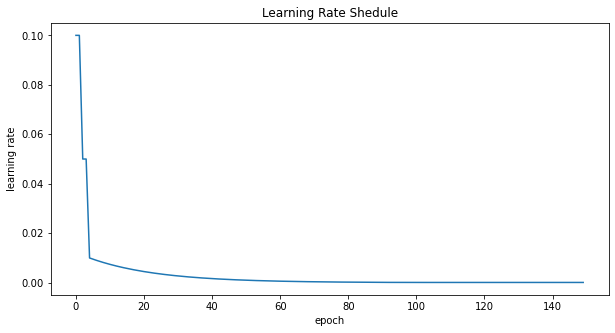

In [23]:
epochs = np.arange(0, 150)
learning_rates = [schedule(epoch) for epoch in epochs]

plt.figure(figsize=(10, 5))
plt.title("Learning Rate Shedule")
plt.xlabel("epoch")
plt.ylabel("learning rate")


plt.plot(epochs, learning_rates)
plt.show()

In [26]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

callbacks = [
    TensorBoard(log_dir=log_dir, update_freq = tensoarboard_fq),
    EarlyStopping(monitor = 'val_loss', min_delta = 1e-3, patience = 3, verbose = 1),
    ModelCheckpoint(
        filepath = './checkpoints/Ipix.{epoch}.h5',
        monitor='val_loss',
        mode='max',
        save_best_only= True,
        verbose = 1
    ),
    LearningRateScheduler(schedule, verbose=1)
]

In [ ]:
history = colorizer.fit(train_probe, 
                steps_per_epoch = train_probe_spe, 
                validation_data = val_probe,
                validation_steps = val_probe_spe,
                epochs = 60,
                callbacks = callbacks,
                shuffle = False)

Epoch 1/60

Epoch 00001: LearningRateScheduler reducing learning rate to 0.1.
10/10 [==============================] - 21s 2s/step - loss: 116.0259 - categorical_crossentropy: 3.3146 - categorical_accuracy: 0.3051 - val_loss: 138.9845 - val_categorical_crossentropy: 3.3774 - val_categorical_accuracy: 0.1131

Epoch 00001: val_loss improved from -inf to 138.98448, saving model to ./checkpoints\Ipix.1.h5
Epoch 2/60

Epoch 00002: LearningRateScheduler reducing learning rate to 0.1.
10/10 [==============================] - 18s 1s/step - loss: 151.4125 - categorical_crossentropy: 3.3945 - categorical_accuracy: 0.3025 - val_loss: 148.5698 - val_categorical_crossentropy: 3.5615 - val_categorical_accuracy: 0.1499

Epoch 00002: val_loss improved from 138.98448 to 148.56979, saving model to ./checkpoints\Ipix.2.h5
Epoch 3/60

Epoch 00003: LearningRateScheduler reducing learning rate to 0.05.
10/10 [==============================] - 15s 1s/step - loss: 113.2623 - categorical_crossentropy: 3.3925 -